# Tutorial 4: Modeling

## Project description

In this tutorial you will implement custom class and make them work together in the RSTT framework, this include a Player class, a Solver, a scheduler and a Ranking. The project is practical as it implements an actual ranking and generate somewhat realistic syntethic data to evaluate its behaviour. For more information on the 

#### League of Legends Global Power Ranking 
In September 2024, Riot Games introduced the **[Global Power Ranking](https://lolesports.com/en-US/news/dev-diary-unveiling-the-global-power-rankings)** for professional League of Legends teams. At is core,  a modified Elo system not only ratin teams, but also regions as part of an international ecosystem.

Additionaly to the Global Power Ranking, we also build a simple **Calendar**. The Calendar responsability is to to generate a somewhat realistic/meaningfull synthetic dataset to evaluate ranking design.
By following the structure of *League of Legend* international competition, it produces data suited for the ranking considerations. You can find detail about it on [Liquipedia](https://liquipedia.net/leagueoflegends/Main_Page)

In this notebook, you will learn how to:
- Design a ranking in the spirit of the package
- Use and combine format of competition to create a complex dataset.


From there on, we will simply refer to *GPR* for the ranking, and *LoL* for League of Legends

#### Tutorial Structure

The goal is to make the notebook work. To achieve this you need to implement several components of the rstt framework.


In the *project* forlder you'll find python module where you work on your implement.

## 1. StagedEvent: Implementation of a Competition

[Competition](https://rstt.readthedocs.io/en/latest/rstt.scheduler.tournament.html#rstt.scheduler.tournament.competition.Competition) is an abstract class from which inherit tournament format such as [Round-Robin](https://rstt.readthedocs.io/en/latest/rstt.scheduler.tournament.html#rstt.scheduler.tournament.groups.RoundRobin) or [Single Elimination Bracket](https://rstt.readthedocs.io/en/latest/rstt.scheduler.tournament.html#rstt.scheduler.tournament.knockout.SingleEliminationBracket). The LoL calendar consist of events for which the rstt already provides a corresponding implementation. For tutorial purpose, we propose to work on a **StagedEvent** class (where different format are played in a succession of stages) to illustrate the devellopement process.

When working on a Competition, you want to be able to instanciate it with seedings, a solver and a name (used as identifier). You also want to 'register' participants and 'run' it. The following code snippet illustrate how the magic happends. It is **not** the exact implementation, but gives the necessary information to understand the logic of the class.

```python
def run(self):
    self.start(): ->
        self.seeding = self.seeding.fit(self.participants)
        self._initialise() # Optional Override (TODO ?)
    self.play(): ->
        while not self.finished:
            games = self.generate_games() # Abstract Method (TODO 1)
            games = self.play_games(games)
            self.edit(games): ->
                self.played_matches.append(games)
                self._update() # Optional Override (TODO ?)
                self.__finished = self._end_of_Stage() # Aabstract Method (TODO 2)
    self.trophies(): ->
        self._standing() # Abstract Method (TODO 3)
        for player in self.participants:
            player.collect(self)
```

In the project/stagedevent.py file there is a StageEvent class for you to fill. 

#### TODO:
Make sure the next cell is exectuable

In [1]:
from rstt import Player, BTRanking, BetterWin
from rstt import RoundRobin, SingleEliminationBracket, DoubleEliminationBracket

#from LoL.project.stagedevent import StagedEvent
from project import StagedEvent


# simulation parameters
teams = Player.create(nb=8)
gt = BTRanking(name='GroundTruth', players=teams)
solver = BetterWin()

# competition parameters
tournaments = [RoundRobin, SingleEliminationBracket, DoubleEliminationBracket]
names = ['PlayIns', 'MainStage', 'PlayOffs']

# try your implementation 
test = StagedEvent(name='test', seeding=gt, solver=solver, tournaments=tournaments, stage_names=names)
test.registration(teams)
test.run()

## 2. Global Power Ranking: Implementation of a Ranking

[Ranking]() in rstt consists of:
- a [standing](): sorts automatically competitors accordingly to their ratings.
- a [datamodel](): container for rating.
- a [backend](): tool to infer ratings, 'the maths'. 
- an [handler](): a workflow handling the update from observations to new ratings.

It is possible to instanciate a ranking simply by specifying the suited components. However, it is also possible to inherit from the class and override the [forward](https://rstt.readthedocs.io/en/latest/rstt.ranking.html#rstt.ranking.ranking.Ranking.forward) method which allows us to tune the ranking state at update time. The following pseudo-code illustrate the default implementation.

```python
def update(self, *args, **kwargs):
    self.forward(*args, **kwargs) ->
        self.handler.handle_observation(infer=self.backend, datamodel=self.datamodel, *args, **kwargs)
    # automatic ordering of the standing
```

Two important remarks. First the ranking **does not care** about ratings explicitly. It is an implict agreement between the components. As long as the backend can manipulate the ratings provided by the handler (and returned by datamodel.get) it should work. It is recommanded to not 'hard code' ratings so that the ranking keeps maximal flexibility and that component remains as independant from each others as possible. Secondly, 'observations' - the things that justify a ranking update, passed as *args **kwargs - are dealt by the handler. The handler needs to extract the relevant information from it. You are free to decide what the ranking takes as input and how to process them.

#### 2.1 Global Power Ranking Logic and Structure

The GPR has its own specificity aswell. It rate leagues, this means we need dedicated Player to represent them because ranking and datamodel are designed for SPlayer. Ratings are evaluated game by game over a time window using an elo rational where games do not all have the same importance. These *extra* notions are develloped in the utils module.

- (A) 'league' players
- (B) a database
- (C) adjust game importance
- (D) reset ratings (so that only the game in the time period count)
- (E) identify the scene and stage (regional/international) of an event

In the turorial, we use a consistent naming convention (define in the scene module) for competition. This way we can extract the needed information to set the importance of the corresponding game. This mean the GPR will take an 'event: Event' parameter  for update (refered as observation). 



In [2]:
from project import GlobalRanking, LeagueSystem
from project.scene import Region

# teams
teams_by_leagues = {region: Player.create(nb=4) for region in list(Region)[:2]}
ecosystem = LeagueSystem(teams_by_leagues)

# ranking parameters
x, y, team_elo, league_elo = 0.8, 0.2, 1300, 1300
gpr = GlobalRanking(name='Global Power Ranking', ecosystem=ecosystem, x=x, y=y, team_elo=team_elo, league_elo=league_elo)
gpr.plot()

----------- Global Power Ranking -----------


In [3]:
# 1. check ranking empty (no games have been played, window is empty !)
print('Empty Ranking at instanciation:', len(gpr) == 0)

# 2. check the Power score formula
team = ecosystem.teams()[0] # a team from the system
rating = gpr.datamodel.get(team) # its rating
points = gpr.datamodel.ordinal(rating) # the associated score
print('Ordinal implements the Power Score Formula:', points == x*team_elo + y*league_elo)

Empty Ranking at instanciation: True
Ordinal implements the Power Score Formula: True


In [4]:
gt = BTRanking('Consensus Ranking', players=ecosystem.teams())
gt.plot()

----------- Consensus Ranking -----------
   0.          Marc Fields       2527
   1.       Jeffrey Hebert       2401
   2.         Toni Manning       1997
   3.       Douglas Oliver       1841
   4.       Abraham Arroyo       1730
   5.         Curtis Miele       1384
   6.        Cheryl Bolton       1327
   7.        Jason Johnson       1115


In [5]:
import json
from collections import defaultdict

import rstt.config as cfg

#region_mapping = defaultdict(lambda: LCP)
region_mapping = {}
region_mapping['NorthAmerica'] = Region.LTAN
region_mapping['Europe'] = Region.LEC
region_mapping['Korea'] = Region.LCK
region_mapping['China'] = Region.LPL
region_mapping['Brazil'] = Region.LTAS
region_mapping['LatinAmerica'] = Region.LTAS
region_mapping['AsiaPacific'] = Region.LCP
region_mapping['Vietnam'] = Region.LCP
region_mapping['Japan'] = Region.LCP


# set default behaviour for Player class
cfg.PLAYER_DIST = lambda: 1000
cfg.PLAYER_DIST_ARGS = {}
teams = defaultdict(lambda: [])

# read data
with open('data/teams.json', 'r') as file:
    data = json.load(file)

# create player instance for each teams
for team in data['teams']:
    teams[region_mapping[team['region']]].append(Player(name=team['name'], level=team['level']))

# store in a league system
ecosystem = LeagueSystem(teams)

# display the population
for league, lts in teams.items():
    print(league, len(lts))

ecosystem.teams(Region.LCP)
# TODO: some test like number of teams/regions league players etc

LTAN 8
LEC 10
LCK 10
LPL 17
LCP 20
LTAS 16


[Player - name: CTBC Flying Oyster, level: 1189,
 Player - name: Deep Cross Gaming, level: 1147,
 Player - name: Frank Esports, level: 1184,
 Player - name: HELL PIGS, level: 1063,
 Player - name: J Team, level: 1117,
 Player - name: PSG Talon, level: 1323,
 Player - name: West Point Esports, level: 1053,
 Player - name: CERBERUS Esports, level: 1077,
 Player - name: GAM Esports, level: 1254,
 Player - name: MGN Blue Esports, level: 1053,
 Player - name: Team Flash, level: 1069,
 Player - name: Team Secret, level: 1134,
 Player - name: Team Whales, level: 1128,
 Player - name: Vikings Esports, level: 1174,
 Player - name: AXIZ CREST, level: 1000,
 Player - name: Burning Core Toyama, level: 1000,
 Player - name: DetonatioN FocusMe, level: 1106,
 Player - name: Fukuoka HAWKS gaming, level: 1147,
 Player - name: Sengoku Gaming, level: 1125,
 Player - name: V3 Esports, level: 1000]

In [6]:
%%time

from project.gpr.utils import get_event_infos, EventInfos
#from project.scene import AUDIENCE_MAPPING, REGIONAL, INTERNATIONAL, STAGES, FINALS
from project import calendar, event_qualification, year_schedule
from project.scene import Finals

from rstt import LogSolver, BasicElo

# population

# ranking 'elo' params
team_elo = 1300
league_elo = 1300
lc = 600

# window params
ly = len(year_schedule(0,1)) # event per year
stage_per_event = 3
team_years = 2 # nb year for the team rating window
league_years = 3 # nb year for the league rating window
window_ranges = {'Team': team_years*ly*stage_per_event, 'League': league_years*ly*stage_per_event}

# power score params
x = 0.8 # weight of team rating
y = 0.2 # weight of league rating

# rankings
gt = BTRanking('GroundTruth', players=ecosystem.teams())
elo = BasicElo('Elo Baseline', players=ecosystem.teams())
gpr = GlobalRanking(name='Global Power Ranking', ecosystem=ecosystem, x=x, y=y, team_elo=team_elo, league_elo=league_elo, lc=lc, mode_range=window_ranges)

# calendar parameters
start = 2024
duration = 100

# result tracking
ranking_state = {elo.name: [], gpr.name: [], gt.name: []}


# Simulation
for event in calendar(start, start+duration, solver=LogSolver(lc=600), seeding=gpr, source='data/qualifications.json'):
    infos = get_event_infos(event)
    invitations, qualifications = event_qualification(infos, ecosystem, gpr.dataset, source='data/qualifications.json')
    event.registration(invited=invitations, qualified=qualifications)
    event.run()

    if infos.region in Finals:
        print(event.name())
        
        gpr.update(event=None)
        ranking_state[elo.name].append([elo.point(team) for team in ecosystem.teams()])
        ranking_state[gpr.name].append([gpr.point(team) for team in ecosystem.teams()])
        ranking_state[gt.name].append([gt.point(team) for team in ecosystem.teams()])
    
    for stage in event.stages:
        elo.update(games=stage.games())
        gpr.dataset.add(stage)

    if infos.region in Finals:
        gpr.update(event=None)
        ranking_state[elo.name].append([elo.point(team) for team in ecosystem.teams()])
        ranking_state[gpr.name].append([gpr.point(team) for team in ecosystem.teams()])
        ranking_state[gt.name].append([gt.point(team) for team in ecosystem.teams()])



FirstStand Winter 2024 
MSI Spring 2024 
Worlds Summer 2024 
FirstStand Winter 2025 
MSI Spring 2025 
Worlds Summer 2025 
FirstStand Winter 2026 
MSI Spring 2026 
Worlds Summer 2026 
FirstStand Winter 2027 
MSI Spring 2027 
Worlds Summer 2027 
FirstStand Winter 2028 
MSI Spring 2028 
Worlds Summer 2028 
FirstStand Winter 2029 
MSI Spring 2029 
Worlds Summer 2029 
FirstStand Winter 2030 
MSI Spring 2030 
Worlds Summer 2030 
FirstStand Winter 2031 
MSI Spring 2031 
Worlds Summer 2031 
FirstStand Winter 2032 
MSI Spring 2032 
Worlds Summer 2032 
FirstStand Winter 2033 
MSI Spring 2033 
Worlds Summer 2033 
FirstStand Winter 2034 
MSI Spring 2034 
Worlds Summer 2034 
FirstStand Winter 2035 
MSI Spring 2035 
Worlds Summer 2035 
FirstStand Winter 2036 
MSI Spring 2036 
Worlds Summer 2036 
FirstStand Winter 2037 
MSI Spring 2037 
Worlds Summer 2037 
FirstStand Winter 2038 
MSI Spring 2038 
Worlds Summer 2038 
FirstStand Winter 2039 
MSI Spring 2039 
Worlds Summer 2039 
FirstStand Winter 2040 


/Users/dbucher/Documents/GitHub/rstt/rstt/utils/competition.py:46: RuntimeWarning: No Valid matchups where found
  warnings.warn(msg, RuntimeWarning)


Worlds Summer 2079 
FirstStand Winter 2080 
MSI Spring 2080 
Worlds Summer 2080 
FirstStand Winter 2081 
MSI Spring 2081 
Worlds Summer 2081 
FirstStand Winter 2082 
MSI Spring 2082 
Worlds Summer 2082 
FirstStand Winter 2083 
MSI Spring 2083 
Worlds Summer 2083 
FirstStand Winter 2084 
MSI Spring 2084 
Worlds Summer 2084 
FirstStand Winter 2085 
MSI Spring 2085 
Worlds Summer 2085 
FirstStand Winter 2086 
MSI Spring 2086 
Worlds Summer 2086 
FirstStand Winter 2087 
MSI Spring 2087 
Worlds Summer 2087 
FirstStand Winter 2088 
MSI Spring 2088 
Worlds Summer 2088 
FirstStand Winter 2089 
MSI Spring 2089 
Worlds Summer 2089 
FirstStand Winter 2090 
MSI Spring 2090 
Worlds Summer 2090 
FirstStand Winter 2091 
MSI Spring 2091 
Worlds Summer 2091 
FirstStand Winter 2092 
MSI Spring 2092 
Worlds Summer 2092 
FirstStand Winter 2093 
MSI Spring 2093 
Worlds Summer 2093 
FirstStand Winter 2094 
MSI Spring 2094 
Worlds Summer 2094 
FirstStand Winter 2095 
MSI Spring 2095 
Worlds Summer 2095 
Firs

In [7]:
from scipy import stats

corr = {gpr.name: [stats.kendalltau(x, y)[0] for x,y in zip(ranking_state[gpr.name], ranking_state[gt.name])],
        elo.name: [stats.kendalltau(x, y)[0] for x,y in zip(ranking_state[elo.name], ranking_state[gt.name])]}

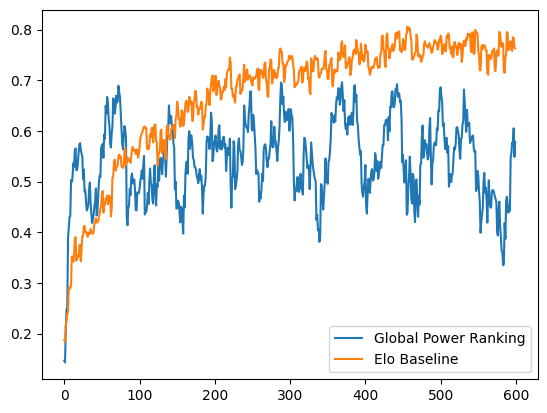

In [8]:
import matplotlib.pyplot as plt

plt.plot(corr[gpr.name], label=gpr.name)
plt.plot(corr[elo.name], label=elo.name)
plt.legend()

In [9]:
top = 10
stats.kendalltau(elo[gt[:top]], gt[gt[:top]])

SignificanceResult(statistic=np.float64(0.5555555555555555), pvalue=np.float64(0.02860945767195767))

In [10]:
top = 10
stats.kendalltau(gpr[gt[:top]], gt[gt[:top]])

SignificanceResult(statistic=np.float64(0.7333333333333333), pvalue=np.float64(0.002212852733686067))

In [11]:
gpr[gt[:top]]

[0, 2, 1, 9, 3, 6, 22, 10, 11, 12]

In [12]:
from rstt import Ranking

def accuracy(ref: Ranking, test: Ranking, top: int):
    targets = ref[:top]
    predict = test[:top]
    positive = [p for p in predict if p in targets]
    return len(positive)/len(targets)

print(accuracy(gt, elo, 10), accuracy(gt, gpr, 10))

0.9 0.6


In [13]:
gt.plot()

----------- GroundTruth -----------
   0.        Gen.G Esports       1663
   1.      Bilibili Gaming       1602
   2.  Hanwha Life Esports       1572
   3.          Top Esports       1508
   4.           G2 Esports       1478
   5.                   T1       1467
   6.                Dplus       1445
   7.            JD Gaming       1440
   8.           KT Rolster       1410
   9.          LNG Esports       1407
  10.         Weibo Gaming       1391
  11.    Ninjas in Pyjamas       1376
  12.               Fnatic       1372
  13.          Team Liquid       1362
  14.      Anyone's Legend       1352
  15.             Team BDS       1344
  16.             FlyQuest       1342
  17.            PSG Talon       1323
  18.      FunPlus Phoenix       1320
  19.              Team WE       1310
  20.               Freecs       1309
  21.           LGD Gaming       1307
  22.        MAD Lions KOI       1302
  23.            Oh My God       1299
  24.               Cloud9       1299
  25.         

## Simulation Model

In [14]:
from project.model import MetaData, LoLTeam, LoLSolver
from project.scene import Role
from rstt import GaussianPlayer, Duel

# Instanciation
ROLES = {r: w for r, w in zip(Role, [0.1, 0.25, 0.2, 0.3, 0.15])}
BLevel, RLevel = 1500, 1500
Bs, Rs = 75, 75
BLUE = GaussianPlayer('BlueSide', mu=BLevel, sigma=Bs)
RED = GaussianPlayer('RedSide', mu=RLevel, sigma=Rs)
meta = MetaData(ROLES, BLUE, RED)
solver = LoLSolver(meta=meta)

# Main feature usage
meta.update()

In [15]:


team1 = LoLTeam('TeamBlue', {r: Player('dummy', 1700) for r in Role})
team2 = LoLTeam('TeamRed', {r: Player('dummy', 1100) for r in Role})

for _ in range(20):
    meta.update({})
    print(meta.blue().level() - meta.red().level(), solver.probabilities(Duel(team1, team2)))

23.79669445654281 [0.9163615985460638, 0.08363840145393624]
169.85906834094385 [0.9504730742563732, 0.04952692574362674]
-203.4940677818406 [0.8207809917213945, 0.17921900827860546]
-18.679804577077675 [0.9029901121743336, 0.09700988782566652]
-145.20498751541254 [0.8513641208534768, 0.14863587914652332]
44.51700983117985 [0.9222577184189307, 0.07774228158106936]
-96.22861174586114 [0.8736135841524858, 0.12638641584751423]
-86.78522612696725 [0.8775611029232556, 0.12243889707674424]
1.9023495246931361 [0.9096924599281855, 0.09030754007181441]
-44.756816518619644 [0.893863251882778, 0.10613674811722205]
90.80389637429926 [0.9340761651085538, 0.06592383489144617]
140.1055554120046 [0.9448130222057526, 0.05518697779424743]
-96.59286558605481 [0.8734591600239063, 0.12654083997609372]
-76.23363021239561 [0.8818459110410657, 0.11815408895893427]
-118.24960657424981 [0.8639844387054337, 0.13601556129456624]
-137.45442308521478 [0.8550888084536727, 0.14491119154632726]
-148.07407664253356 [0.8

In [16]:
team1.level(meta.weights())

1700.0

In [17]:
roleA = {Role.Toplaner: Player("toplanerA", 1300),
         Role.Jungle: Player("junglerA", 1400),
         Role.Midlaner: Player("midlanerA", 1500),
         Role.Botlaner: Player("adcA", 1600),
         Role.Support: Player("supportB", 1700)}

roleB = {Role.Toplaner: Player("toplanerB", 1700),
         Role.Jungle: Player("junglerB", 1600),
         Role.Midlaner: Player("midlanerB", 1500),
         Role.Botlaner: Player("adcB", 1400),
         Role.Support: Player("supportB", 1300)}

teamA = LoLTeam('TeamBlue', roleA)
teamB = LoLTeam('TeamRed', roleB)

In [18]:
import random

role_weights = [0.1, 0.2, 0.3, 0.4, 0.5]
for _ in range(20):
    random.shuffle(role_weights)
    meta.update(weights={r: w for r, w in zip(Role, role_weights)}, blue=False, red=False)
    print(meta.weights(), solver.probabilities(Duel(teamA, teamB)))
    print()

{<Role.Toplaner: 'Toplaner'>: 0.3, <Role.Jungle: 'Jungler'>: 0.5, <Role.Midlaner: 'Midlaner'>: 0.2, <Role.Botlaner: 'Botlaner'>: 0.4, <Role.Support: 'Support'>: 0.1} [0.40123130754615927, 0.5987686924538408]

{<Role.Toplaner: 'Toplaner'>: 0.5, <Role.Jungle: 'Jungler'>: 0.3, <Role.Midlaner: 'Midlaner'>: 0.1, <Role.Botlaner: 'Botlaner'>: 0.4, <Role.Support: 'Support'>: 0.2} [0.40123130754615927, 0.5987686924538408]

{<Role.Toplaner: 'Toplaner'>: 0.3, <Role.Jungle: 'Jungler'>: 0.5, <Role.Midlaner: 'Midlaner'>: 0.1, <Role.Botlaner: 'Botlaner'>: 0.2, <Role.Support: 'Support'>: 0.4} [0.4512397002893132, 0.5487602997106867]

{<Role.Toplaner: 'Toplaner'>: 0.2, <Role.Jungle: 'Jungler'>: 0.1, <Role.Midlaner: 'Midlaner'>: 0.3, <Role.Botlaner: 'Botlaner'>: 0.5, <Role.Support: 'Support'>: 0.4} [0.5658291284407271, 0.4341708715592729]

{<Role.Toplaner: 'Toplaner'>: 0.5, <Role.Jungle: 'Jungler'>: 0.4, <Role.Midlaner: 'Midlaner'>: 0.1, <Role.Botlaner: 'Botlaner'>: 0.2, <Role.Support: 'Support'>: 0.3} 

In [19]:
from rstt.player import CyclePlayer

teamC = LoLTeam('TeamCycle', {r: CyclePlayer("dummy", 1500, 80, 5) for r in Role})
teamF = LoLTeam('TeamFix', {r: Player('dummy', 1500) for r in Role})
solver = LoLSolver(meta=MetaData())

for _ in range(20):
    random.shuffle(role_weights)
    meta.update(weights={r: w for r, w in zip(Role, role_weights)}, blue=False, red=False)
    teamC.update_level()
    teamF.update_level()
    print(solver.probabilities(Duel(teamC, teamF)))

[0.3952717360179971, 0.6047282639820029]
[0.4067885452077106, 0.5932114547922895]
[0.4274211798703145, 0.5725788201296854]
[0.4553980332735111, 0.5446019667264889]
[0.4880333212203179, 0.5119666787796822]
[0.5219404173480326, 0.47805958265196735]
[0.5535230799294574, 0.4464769200705426]
[0.5795620847348036, 0.42043791526519636]
[0.5976341027888336, 0.4023658972111664]
[0.6062394276481148, 0.3937605723518852]
[0.6047282639820007, 0.3952717360179992]
[0.5932114547922842, 0.4067885452077158]
[0.5725788201296773, 0.4274211798703227]
[0.5446019667264789, 0.4553980332735211]
[0.511966678779671, 0.488033321220329]
[0.47805958265195636, 0.5219404173480435]
[0.4464769200705332, 0.5535230799294668]
[0.420437915265189, 0.579562084734811]
[0.402365897211162, 0.597634102788838]
[0.39376057235188666, 0.6062394276481133]
